In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

In [2]:
tf.__version__

'2.14.0'

In [132]:
import os

gpu_memory = os.popen('nvidia-smi --query-gpu=memory.used --format=csv,nounits,noheader').read().strip()
print("GPU Memory Usage (MB):", gpu_memory)

GPU Memory Usage (MB): 3


In [133]:

(train_images, train_labels), (val_images, val_labels) = tf.keras.datasets.mnist.load_data()

train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)

train_images = train_images.astype('float32')/255.0
val_images = val_images.astype('float32')/255.0

train_images = tf.image.grayscale_to_rgb(tf.image.resize(train_images, (32,32)))
val_images = tf.image.grayscale_to_rgb(tf.image.resize(val_images, (32,32)))

train_labels = tf.keras.utils.to_categorical(train_labels, 10)
val_labels = tf.keras.utils.to_categorical(val_labels, 10)

def data_generator(images, labels, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.cache()
    dataset = dataset.shuffle(20000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = data_generator(train_images, train_labels)
val_dataset = data_generator(val_images, val_labels)

In [134]:
print(f'1. train_labels :{train_labels.shape}, val_labels : {val_labels.shape}')

1. train_labels :(60000, 10), val_labels : (10000, 10)


(64, 32, 32, 3)
<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
(64, 10)
Normalized values:  (0.0, 0.99215686)


2024-08-17 19:00:58.449817: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


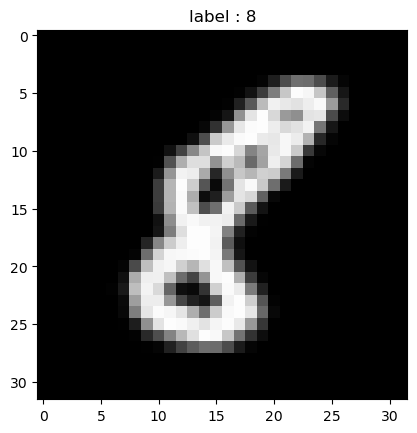

In [135]:
for img_batch, label_batch in train_dataset.take(1):
    print(img_batch.shape)
    print(type(img_batch.shape))
    print(label_batch.shape)
    img = np.array(img_batch)
    label = np.argmax(label_batch)
    print('Normalized values: ', (np.min(img_batch[0]), np.max(img_batch[0])))
    plt.imshow(img[0])
    plt.title(f"label : {label}")

In [136]:

val_batches = tf.data.experimental.cardinality(val_dataset) #calcute no.of batches in val_set

test_dataset = val_dataset.take(val_batches // 10) #take the first 20% of the val set, and create a new test set
val_dataset = val_dataset.skip(val_batches // 10) #skip the first 20% of the data used for creating test set
batch_size = 32

print('number of val batches: %d' % val_batches)
print('number of images in val set :', len(val_dataset)*batch_size)
print('number of test batches :%d', tf.data.experimental.cardinality(test_dataset))
print('number of images in test_set:', len(test_dataset)*batch_size)

number of val batches: 157
number of images in val set : 4544
number of test batches :%d tf.Tensor(15, shape=(), dtype=int64)
number of images in test_set: 480


In [137]:
val_batches = tf.data.experimental.cardinality(val_dataset) #calcute no.of batches in val_set

test_dataset = val_dataset.take(val_batches // 10) #take the first 20% of the val set, and create a new test set
val_dataset = val_dataset.skip(val_batches // 10) #skip the first 20% of the data used for creating test set
batch_size = 32

print('number of val batches: %d' % val_batches)
print('number of images in val set :', len(val_dataset)*batch_size)
print('number of test batches :%d', tf.data.experimental.cardinality(test_dataset))
print('number of images in test_set:', len(test_dataset)*batch_size)

number of val batches: 142
number of images in val set : 4096
number of test batches :%d tf.Tensor(14, shape=(), dtype=int64)
number of images in test_set: 448


In [126]:
# import shutil
# # test_dataset.save('test_dataset')
# shutil.make_archive("test_dataset", "zip", "test_dataset")

'/home/s2310144/workshop/Underspecification/mnist/test_dataset.zip'

In [46]:
cnn_model = keras.Sequential(
    [
        keras.Input(shape=(32,32,3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

In [47]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2304)             

In [48]:
%%time
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])

history = cnn_model.fit(train_dataset, batch_size=128, epochs=10,
                            validation_data=(val_dataset))

Epoch 1/10
938/938 [==============================] - 5s 5ms/step - loss: 0.2327 - accuracy: 0.9280 - val_loss: 0.0605 - val_accuracy: 0.9802
Epoch 2/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0845 - accuracy: 0.9745 - val_loss: 0.0417 - val_accuracy: 0.9865
Epoch 3/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0641 - accuracy: 0.9798 - val_loss: 0.0341 - val_accuracy: 0.9882
Epoch 4/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0559 - accuracy: 0.9826 - val_loss: 0.0322 - val_accuracy: 0.9878
Epoch 5/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0474 - accuracy: 0.9848 - val_loss: 0.0287 - val_accuracy: 0.9904
Epoch 6/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0424 - accuracy: 0.9867 - val_loss: 0.0238 - val_accuracy: 0.9929
Epoch 7/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0421 - accuracy: 0.9870 - val_loss: 0.0248 - val_accuracy: 0.9914
Epoch 

128/128 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9932
Validation accuracy: 0.9932


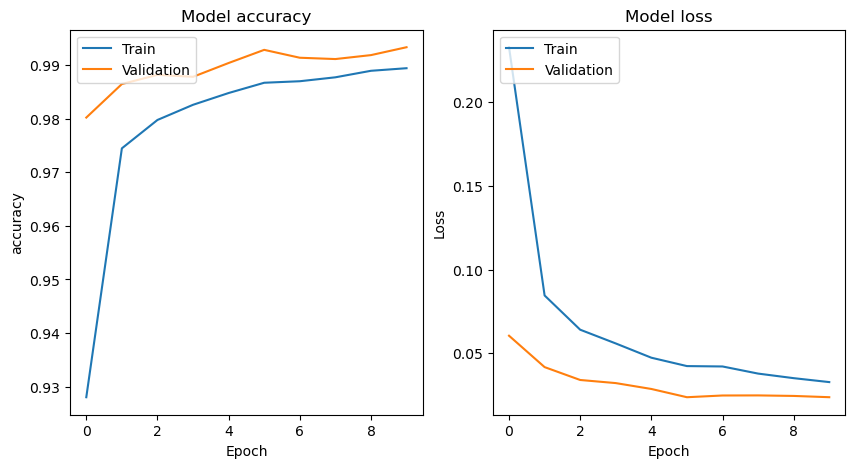

In [49]:
# Evaluate the model
val_loss, val_acc = cnn_model.evaluate(val_dataset)
print(f"Validation accuracy: {val_acc:.4f}")


plt.figure(figsize=(10,5))
#plot training & validation accuracy values
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# cnn_model.save('models/std/cnn_mnist_std.h5')

In [52]:
base_resnet = tf.keras.applications.ResNet50(weights= None,
                                             include_top=False,
                                             input_shape=(32, 32, 3))

#add fully connected layers
resnet_model= models.Sequential()

resnet_model.add(base_resnet)
resnet_model.add(layers.GlobalAveragePooling2D())

resnet_model.add(layers.Dense(256, activation='relu'))
resnet_model.add(layers.Dropout(0.4))
resnet_model.add(layers.Dense(10, activation='softmax'))

#train with MNIST
resnet_model.compile(optimizer=keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=['accuracy'])

In [53]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24114826 (91.99 MB)
Trainable params: 24061706 (91.79 MB)
Non-trainable params: 53120 (207.50 KB)
________

Epoch 1/10
3750/3750 [==============================] - 289s 74ms/step - loss: 0.5189 - accuracy: 0.8645 - val_loss: 0.6676 - val_accuracy: 0.8217
Epoch 2/10
3750/3750 [==============================] - 275s 73ms/step - loss: 0.3184 - accuracy: 0.9243 - val_loss: 0.1459 - val_accuracy: 0.9649
Epoch 3/10
3750/3750 [==============================] - 275s 73ms/step - loss: 0.3010 - accuracy: 0.9249 - val_loss: 0.0934 - val_accuracy: 0.9776
Epoch 4/10
3750/3750 [==============================] - 274s 73ms/step - loss: 0.2137 - accuracy: 0.9477 - val_loss: 0.2944 - val_accuracy: 0.9274
Epoch 5/10
3750/3750 [==============================] - 274s 73ms/step - loss: 0.2105 - accuracy: 0.9476 - val_loss: 0.0649 - val_accuracy: 0.9822
Epoch 6/10
3750/3750 [==============================] - 274s 73ms/step - loss: 0.1147 - accuracy: 0.9746 - val_loss: 0.0475 - val_accuracy: 0.9875
Epoch 7/10
3750/3750 [==============================] - 274s 73ms/step - loss: 0.1018 - accuracy: 0.9766 - val_loss: 0

NameError: name 'resnetnet_std' is not defined

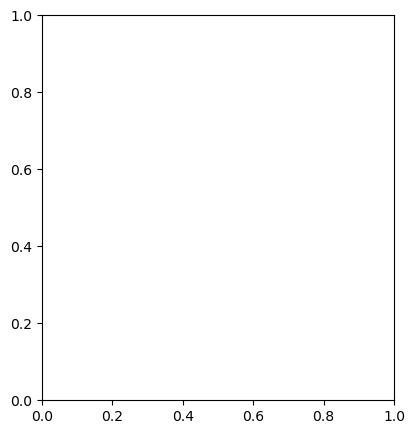

In [87]:
%%time
resnet_std = resnet_model.fit(train_dataset,
                            epochs=10, 
                            validation_data=val_dataset)

# Save the model if accuracy thresholds are met
resnet_std_train_acc = max(resnet_std.history['accuracy'])
resnet_std_val_acc = max(resnet_std.history['val_accuracy'])

if resnet_std_train_acc > 0.90 and resnet_std_val_acc > 0.90:
    resnet_model.save('models/std/resnet_mnist_std.h5')
    print('Model saved as resnet_std.h5')

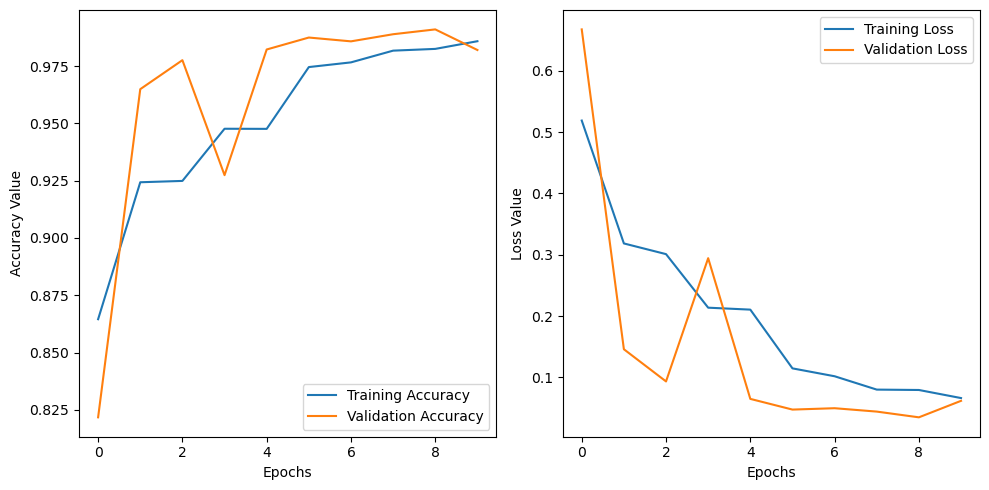

In [88]:
# Plot accuracy
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(resnet_std.history['accuracy'], label='Training Accuracy')
plt.plot(resnet_std.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(resnet_std.history['loss'], label='Training Loss')
plt.plot(resnet_std.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
base_densenet = tf.keras.applications.DenseNet121(weights=None, 
                                                  include_top=False,
                                                  input_shape=(32, 32, 3))

#add fully connected layers
densenet_model= models.Sequential()

densenet_model.add(base_densenet)
densenet_model.add(layers.GlobalAveragePooling2D())

densenet_model.add(layers.Dense(256, activation='relu'))
densenet_model.add(layers.Dropout(0.4)),
densenet_model.add(layers.Dense(10, activation='softmax'))

#train with MNIST
densenet_model.compile(optimizer=keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=['accuracy'])

In [60]:
densenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 256)               262400    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 10)                2570      
                                                                 
Total params: 7302474 (27.86 MB)
Trainable params: 7218826 (27.54 MB)
Non-trainable params: 83648 (326.75 KB)
__________

Epoch 1/10
3750/3750 [==============================] - 523s 133ms/step - loss: 0.2083 - accuracy: 0.9438 - val_loss: 0.0728 - val_accuracy: 0.9776
Epoch 2/10
3750/3750 [==============================] - 496s 132ms/step - loss: 0.1141 - accuracy: 0.9705 - val_loss: 0.0513 - val_accuracy: 0.9859
Epoch 3/10
3750/3750 [==============================] - 495s 132ms/step - loss: 0.0835 - accuracy: 0.9792 - val_loss: 0.0477 - val_accuracy: 0.9872
Epoch 4/10
3750/3750 [==============================] - 495s 132ms/step - loss: 0.0701 - accuracy: 0.9820 - val_loss: 0.0320 - val_accuracy: 0.9908
Epoch 5/10
3750/3750 [==============================] - 493s 132ms/step - loss: 0.0556 - accuracy: 0.9858 - val_loss: 0.0251 - val_accuracy: 0.9925
Epoch 6/10
3750/3750 [==============================] - 494s 132ms/step - loss: 0.0467 - accuracy: 0.9876 - val_loss: 0.0309 - val_accuracy: 0.9910
Epoch 7/10
3750/3750 [==============================] - 493s 132ms/step - loss: 0.0448 - accuracy: 0.9889 - val_

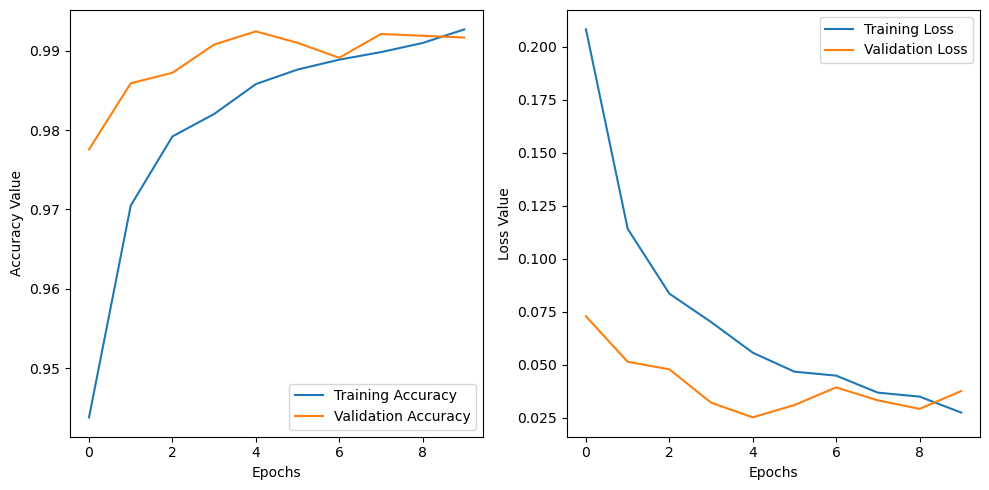

In [96]:
densenet_std = densenet_model.fit(train_dataset, 
                                 epochs=10, 
                                 validation_data=val_dataset)

# Save the model if accuracy thresholds are met
densenet_std_train_acc = max(densenet_std.history['accuracy'])
densenet_std_val_acc = max(densenet_std.history['val_accuracy'])

if densenet_std_train_acc > 0.90 and densenet_std_val_acc > 0.90:
    densenet_model.save('models/std/densenet_mnist_std.h5')
    print('Model saved as densenet_std.h5')

# Plot accuracy
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(densenet_std.history['accuracy'], label='Training Accuracy')
plt.plot(densenet_std.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(densenet_std.history['loss'], label='Training Loss')
plt.plot(densenet_std.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
# Adversarial Training

In [62]:
# cnn_adv.save('models/adv/cnn_mnist_adv.h5')
# resnet_adv.save('models/adv/resnet_mnist_adv.h5')
# densenet_adv.save('models/adv/densenet_mnist_adv.h5')

In [66]:
cnn_std = tf.keras.models.load_model('models/std/cnn_mnist_std.h5')
resnet_std = tf.keras.models.load_model('models/std/resnet_mnist_std.h5')
densenet_std = tf.keras.models.load_model('models/std/densenet_mnist_std.h5')

std_list = [cnn_std, resnet_std, densenet_std]

In [93]:
"""FGSM algorithm"""

def create_adversarial_pattern(model, image, label):
    # image = tf.convert_to_tensor(image) #should be avoided if the images are already in tensor format
    # label = tf.convert_to_tensor(label)
    with tf.GradientTape() as tape:#creates a tf.GradientTape object, which is used to record the gradients of the loss function with respect to the input image.
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad

# Generate Adversarial Examples
def generate_adversarial_test_dataset(dataset, model, epsilon=0.01):
    def gen():
        for images, labels in dataset:
            adv_images = images + epsilon * create_adversarial_pattern(model, images, labels)
            adv_images = tf.clip_by_value(adv_images, 0.0, 1.0)
            yield adv_images, labels
    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(64,10), dtype=tf.int32)
        )
    )

In [78]:
"""generate adversarial test set for standard models"""
adv_test_set_cnn_std = generate_adversarial_test_dataset(test_dataset, cnn_std)
adv_test_set_resnet_std = generate_adversarial_test_dataset(test_dataset, resnet_std)
adv_test_set_densenet_std = generate_adversarial_test_dataset(test_dataset, densenet_std)

Normalized values:  (0.0, 1.0)


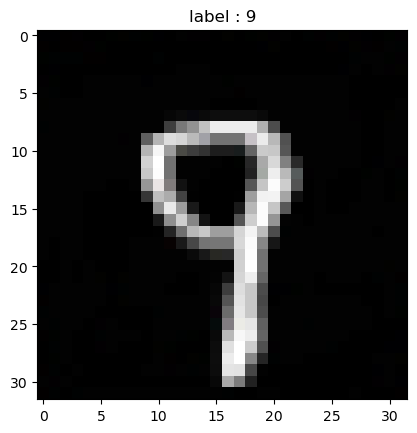

In [131]:
for img_batch, label_batch in adv_test_set_cnn_std.take(1):
    img = np.array(img_batch)
    label = np.argmax(label_batch)
    print('Normalized values: ', (np.min(img_batch[0]), np.max(img_batch[0])))
    plt.imshow(img[0])
    plt.title(f"label : {label}")

In [128]:
# Evaluate std models on original test set (standard test set)
_, std_test_acc_cnn_std = cnn_std.evaluate(test_dataset)
_, std_test_acc_resnet_std = resnet_std.evaluate(test_dataset)
_, std_test_densenet_std = densenet_std.evaluate(test_dataset)

print(f"CNN Std Test Accuracy: {std_test_acc_cnn_std:.4f}")
print(f"ResNet Std Test Accuracy: {std_test_acc_resnet_std:.4f}")
print(f"DenseNet Std Accuracy: {std_test_densenet_std:.4f}")

14/14 [==============================] - 1s 56ms/step - loss: 0.0528 - accuracy: 0.9866
CNN Std Test Accuracy: 0.9888
MLP Std Test Accuracy: 0.9688
MobileNet Std Test Accuracy: 0.9777
ResNet Std Test Accuracy: 0.9766
DenseNet Std Accuracy: 0.9866


In [100]:
# Evaluate std models on the adversarial test set
_, adv_test_acc_cnn_std = cnn_std.evaluate(adv_test_set_cnn_std)
_, adv_test_acc_resnet_std = resnet_std.evaluate(adv_test_set_resnet_std)
_, adv_test_densenet_std = densenet_std.evaluate(adv_test_set_densenet_std)

print(f"CNN Std Adv-Test Accuracy: {adv_test_acc_cnn_std:.4f}")
print(f"ResNet Std Adv-Test Accuracy: {adv_test_acc_resnet_std:.4f}")
print(f"DenseNet Std Adv-Accuracy: {adv_test_densenet_std:.4f}")

14/14 [==============================] - 10s 685ms/step - loss: 0.1316 - accuracy: 0.9688
CNN Std Adv-Test Accuracy: 0.9688
MLP Std Adv-Test Accuracy: 0.9453
MobileNet Std Adv-Test Accuracy: 0.9609
ResNet Std Adv-Test Accuracy: 0.9699
DenseNet Std Adv-Accuracy: 0.9688


In [101]:
std_test_acc_std = [std_test_acc_cnn_std, std_test_acc_resnet_std, std_test_densenet_std]
adv_test_acc_std = [adv_test_acc_cnn_std, adv_test_acc_resnet_std, adv_test_densenet_std]

In [102]:
model_names = ['CNN', 'ResNet', 'DenseNet']
robustness_scores_std = [adv / std for adv, std in zip(adv_test_acc_std, std_test_acc_std)]

for i, score in enumerate(robustness_scores_std):
    print(f"Robustness score for model {i+1}: {score:.4f}")

Robustness score for model 1: 0.9775
Robustness score for model 2: 0.9758
Robustness score for model 3: 0.9840
Robustness score for model 4: 0.9954
Robustness score for model 5: 0.9808
